## Importing Libraries

In [1]:
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from termcolor import colored
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from tensorflow.keras.layers import LSTM, Dense, Dropout, GlobalMaxPooling1D, Bidirectional, Embedding

## Importing Dataset

In [2]:
train_set_path = '/kaggle/input/4-classes-sinhala-preprocessed-splitted-dataset/train.csv'
test_set_path = '/kaggle/input/4-classes-sinhala-preprocessed-splitted-dataset/test.csv'

In [3]:
train_set = pd.read_csv(train_set_path)
test_set = pd.read_csv(test_set_path)

In [4]:
train_set.head()

,Labels,Paragraph
0,3,ෆියට් සමඟ ඇති ආරවුල විසඳී මැදිහත් වීමක් අපේක්ෂ...
1,1,තලේබාන් සංවිධානයේ ජ්යෙෂ්ඨ අණදෙන නිලධාරියා දකුණ...
2,4,දේශීය ශුද්ධ දුරකථන සැලැස්ම නිර්මාණය කරයි විදුල...
3,1,මරණයක් පිළිබඳ කටකතා කිම් ජොං ඉල්ගේ ප්රියතම සහක...
4,3,බලශක්ති වෙළඳපොළෙන් පසුබැසීම ඕස්ට්රේලියා ගෑස් ල...


In [5]:
test_set.head()

,Labels,Paragraph
0,2,අංක ජෝර්ජියා ටෙක් මෙම ජයග්රහණ සැමරීම කිසිදු මන...
1,2,කාටර් ගේ කියන්න දෙයක් නැහැ ලකුණු ක් ලබා ගැනීමෙ...
2,4,අමු ඡායාරූප ආකෘති සඳහා සම්මත ලබා දෙයි වෙනත් ආක...
3,1,පාකින්සන් සඳහා ප්රතිජීවක බලාපොරොත්තු ලාදුරු සහ...
4,3,බ්ලොගයෙන් පිටවන්න ලෙග් ඇතුල් කරන්න ඉහළ ප්රොෆයි...


## Labels

In [6]:
labels = ['World', 'Sports', 'Business & Economics', 'Science & Technology']

## Setting Columns

In [7]:
train_set.columns = ['ClassIndex', 'Paragraph']
test_set.columns = ['ClassIndex', 'Paragraph']

In [8]:
X_train = train_set['Paragraph'].astype(str)
y_train = train_set['ClassIndex'].apply(lambda x: x-1).values

X_test = test_set['Paragraph'].astype(str)
y_test = test_set['ClassIndex'].apply(lambda x: x-1).values

In [9]:
# Finding the max no of words in a sentence in complete data set 

maxlen = X_train.map(lambda x: len(x.split())).max()

In [10]:
print(maxlen)

165


In [11]:
X_train.head()

0    ෆියට් සමඟ ඇති ආරවුල විසඳී මැදිහත් වීමක් අපේක්ෂ...
1    තලේබාන් සංවිධානයේ ජ්යෙෂ්ඨ අණදෙන නිලධාරියා දකුණ...
2    දේශීය ශුද්ධ දුරකථන සැලැස්ම නිර්මාණය කරයි විදුල...
3    මරණයක් පිළිබඳ කටකතා කිම් ජොං ඉල්ගේ ප්රියතම සහක...
4    බලශක්ති වෙළඳපොළෙන් පසුබැසීම ඕස්ට්රේලියා ගෑස් ල...
Name: Paragraph, dtype: object

In [12]:
X_test.head()

0    අංක ජෝර්ජියා ටෙක් මෙම ජයග්රහණ සැමරීම කිසිදු මන...
1    කාටර් ගේ කියන්න දෙයක් නැහැ ලකුණු ක් ලබා ගැනීමෙ...
2    අමු ඡායාරූප ආකෘති සඳහා සම්මත ලබා දෙයි වෙනත් ආක...
3    පාකින්සන් සඳහා ප්රතිජීවක බලාපොරොත්තු ලාදුරු සහ...
4    බ්ලොගයෙන් පිටවන්න ලෙග් ඇතුල් කරන්න ඉහළ ප්රොෆයි...
Name: Paragraph, dtype: object

In [13]:
print(y_train)

[2 0 3 ... 3 3 2]


In [14]:
print(y_test)

[1 1 3 ... 2 2 0]


## Data Distribution

**Train set**

<AxesSubplot:xlabel='ClassIndex', ylabel='count'>

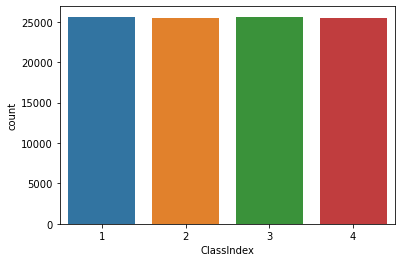

In [15]:
sns.countplot(x=train_set['ClassIndex'])

**Test set**

<AxesSubplot:xlabel='ClassIndex', ylabel='count'>

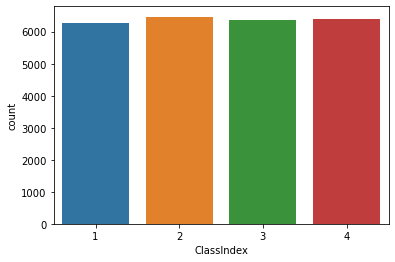

In [16]:
sns.countplot(x=test_set['ClassIndex'])

## Checking Missing Values

In [17]:
train_set.isnull().sum()

ClassIndex    0
Paragraph     2
dtype: int64

In [18]:
test_set.isnull().sum()

ClassIndex    0
Paragraph     0
dtype: int64

## Tokenization

In [19]:
vocabulary_size = 10000 # arbitrarily chosen
embed_size = 32 # arbitrarily chosen

**Creating & fitting Tokenizer**

In [20]:
sinhala_tokens = Tokenizer(num_words = vocabulary_size)

In [21]:
sinhala_tokens.fit_on_texts(X_train.values)

**Tokenizing texts**

In [22]:
X_train = sinhala_tokens.texts_to_sequences(X_train)
X_test = sinhala_tokens.texts_to_sequences(X_test)

**Padding texts**

In [23]:
# pad all the sequences based on the max value

X_train = pad_sequences(X_train, maxlen = maxlen)
X_test = pad_sequences(X_test, maxlen = maxlen)

## Constructing the Bidirectional LSTM Model

In [24]:
model = Sequential()

# Input Layer
model.add(Embedding(vocabulary_size, embed_size, input_length = maxlen))

model.add(Bidirectional(LSTM(128, return_sequences = True))) 
model.add(Bidirectional(LSTM(64, return_sequences = True)))

model.add(GlobalMaxPooling1D()) 

model.add(Dense(1024))
model.add(Dropout(0.25)) 
model.add(Dense(512))
model.add(Dropout(0.25))
model.add(Dense(256))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Dropout(0.25))
model.add(Dense(64))
model.add(Dropout(0.25))

# Output Layer
model.add(Dense(4, activation = 'softmax'))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 165, 32)           320000    
_________________________________________________________________
bidirectional (Bidirectional (None, 165, 256)          164864    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 165, 128)          164352    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              132096    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               5

## Model Architecture

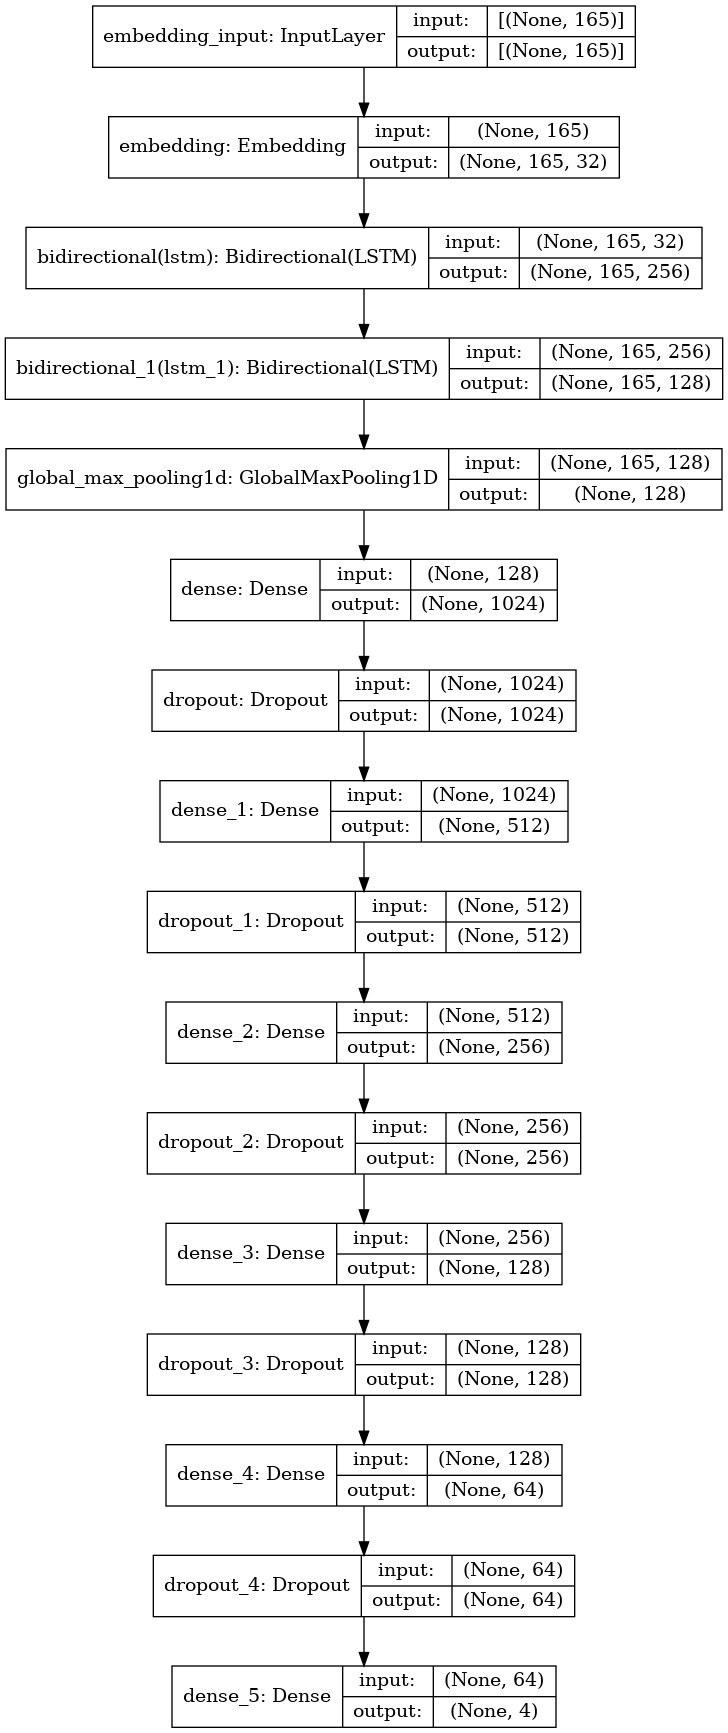

In [26]:
plot_model(model, to_file = '4_classes_bilstm_model.png', show_shapes=True, show_layer_names=True)

## Model Training

**Callbacks**

In [27]:
callbacks = [
    
    EarlyStopping(
        monitor = 'val_accuracy',
        min_delta = 1e-4,
        patience = 4,
        verbose = 1
    ),
    
    ModelCheckpoint(
        filepath = '4_classes_bilstm_weights.h5',
        monitor = 'val_accuracy', 
        mode = 'max', 
        save_best_only = True,
        save_weights_only = True,
        verbose = 1
    ),
    
]

**Compilling**

In [28]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam', 
              metrics = ['accuracy'])

**Training**

In [29]:
epochs = 20
batch_size = 256
validation_data = (X_test, y_test)

In [30]:
hist = model.fit(X_train,
                 y_train,
                 batch_size = batch_size,
                 validation_data = validation_data,
                 epochs = epochs,
                 callbacks = callbacks)

Epoch 1/20
399/399 [==============================] - 38s 78ms/step - loss: 0.4724 - accuracy: 0.8258 - val_loss: 0.3395 - val_accuracy: 0.8851

Epoch 00001: val_accuracy improved from -inf to 0.88515, saving model to 4_classes_bilstm_weights.h5
Epoch 2/20
399/399 [==============================] - 30s 75ms/step - loss: 0.3011 - accuracy: 0.9016 - val_loss: 0.3252 - val_accuracy: 0.8904

Epoch 00002: val_accuracy improved from 0.88515 to 0.89036, saving model to 4_classes_bilstm_weights.h5
Epoch 3/20
399/399 [==============================] - 30s 75ms/step - loss: 0.2590 - accuracy: 0.9128 - val_loss: 0.3450 - val_accuracy: 0.8901

Epoch 00003: val_accuracy did not improve from 0.89036
Epoch 4/20
399/399 [==============================] - 30s 75ms/step - loss: 0.2260 - accuracy: 0.9232 - val_loss: 0.3514 - val_accuracy: 0.8826

Epoch 00004: val_accuracy did not improve from 0.89036
Epoch 5/20
399/399 [==============================] - 30s 75ms/step - loss: 0.1897 - accuracy: 0.9334 - v

## Saving the Model

In [31]:
model.load_weights('4_classes_bilstm_weights.h5')
model.save('4_classes_bilstm_model.h5')
model.save('4_classes_bilstm_model.hdf5')

## Model Accuaracy and Loss Plots

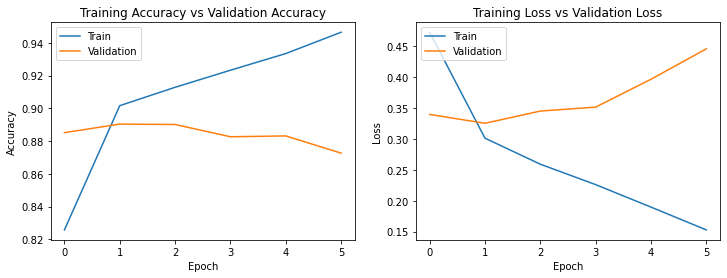

In [32]:
fig , ax = plt.subplots(1,2)
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(hist.history['accuracy'])
ax[0].plot(hist.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc = 'upper left')

ax[1].plot(hist.history['loss'])
ax[1].plot(hist.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc = 'upper left')

plt.show()

## Confusion Matrix

<Figure size 432x288 with 0 Axes>

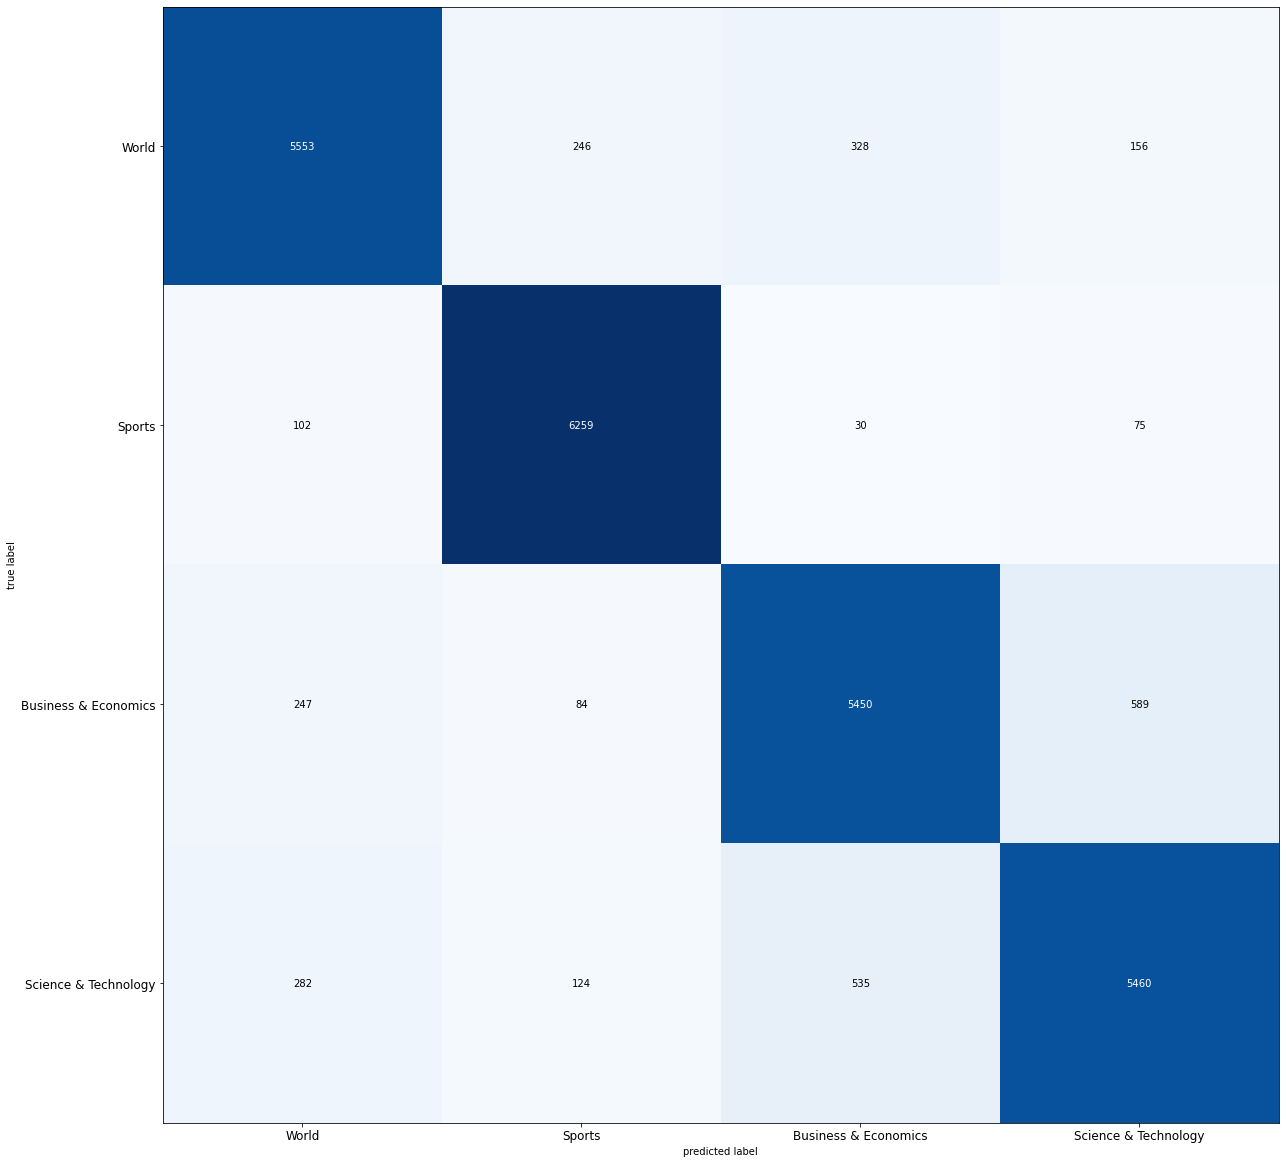

In [33]:
preds = [np.argmax(i) for i in model.predict(X_test)]

cm = confusion_matrix(y_test, preds)

plt.figure()

plot_confusion_matrix(cm, figsize = (20,30), hide_ticks = True, cmap = plt.cm.Blues)

plt.xticks(range(4), labels, fontsize = 12)
plt.yticks(range(4), labels, fontsize = 12)

plt.show()

## Recall, Precision and Accuracy

In [34]:
print("Recall of the model is {:.2f}".format(recall_score(y_test, preds, average = 'micro')))
print("Precision of the model is {:.2f}".format(precision_score(y_test, preds, average = 'micro')))
print("Accuracy of the model is {:.2f}".format(accuracy_score(y_test, preds)))

Recall of the model is 0.89
Precision of the model is 0.89
Accuracy of the model is 0.89


## Getting Preditctions

In [35]:
def modelDemo(sinhala_texts):
    
    test_seq = pad_sequences(sinhala_tokens.texts_to_sequences(sinhala_texts), maxlen = maxlen)
    test_preds = [labels[np.argmax(i)] for i in model.predict(test_seq)]
    
    for sin_txt, label in zip(sinhala_texts, test_preds):
        print('{} - {}'.format(colored(sin_txt, 'yellow'), colored(label, 'blue')))

In [36]:
sinhala_texts = [
             'T20 ලෝක කුසලානය සඳහා වන ශ්‍රී ලංකා කාන්තා සංචිතය ප්‍රකාශයට පත් කෙරේ',
             'නිදහස් සේවකයාට බදු පැනවීම: බදු අය කරන්නේ කාටද?',
             'වනජීවී වෙළඳාමෙන් වෛරස් අවදානම් පිළිබඳ නව සාක්ෂි',
             'ICC කාන්තා T20 ලෝක කුසලානය 2023 | නිල කණ්ඩායම් අනුග්‍රාහකයා හඳුන්වාදීම සහ ශ්‍රී ලංකා කණ්ඩායමේ ජර්සි එළිදැක්වීම.',
             'නිදහස් දින සැමරුම සම්බන්ධයෙන් ශ්‍රී ලංකා කතෝලික සභාව ජනපතිට බැණ වදියි',
             'IMF ආධාර වැඩසටහන ගැන SJB නායකයාගේ අනතුරු ඇඟවීම',
             '#GalaxyS23 සමඟින් ඔහුගේ වැඩිදියුණු කළ ඡායාරූප පෙන්වයි. Galaxy සමඟ JK හි ඔබ කැමතිම ඡායාරූපය කුමක්ද?',
             'Falcon 9 සිය 200 වැනි සාර්ථක මෙහෙයුම දියත් කළ අතර, තවත් SpaceX Starlink චන්ද්‍රිකා 53ක් අද උදෑසන කක්ෂයට ලබා දුන්නේය.',
             'කැලඹිලි සහිත ආර්ථික කාලවලදී, කොටස් මිලදී ගැනීම සඳහා ආන්තික ණය භාවිතා කිරීම ගැන සැලකිලිමත් වන්න',
             'ඉදිරියේදී පැවැත්වීමට නියමිත බෝඩර් ගවස්කාර් කුසලානයේ විස්තර විචාරකයෙකු ලෙස දිනේෂ් කාර්තික් කටයුතු කරනු ඇත',
             'මෙවර විස්සයි විස්ස ලෝක කුසලාන කාන්තා ක්‍රිකට් තරගාවලියට සහභාගී වන ශ්‍රි ලංකා කාන්තා ක්‍රිකට් කණ්ඩායම අද අලුයම දකුණු අප්‍රිකාව බලා පිටත්ව ගොස් තිබේ.',
             '2023 පළාත් පාලන මැතිවරණයට අදාළව තැපැල් ඡන්දය සලකුණු කිරීමේ දින මැතිවරණ කොමිසම විසින් ප්‍රකාශයට පත්කර තිබේ.',
             'දිවයින හරහා ගමන් කරමින් පැවති පීඩන අවපාතය ඊයේ රාත්‍රියේ අඩු පීඩන කලාපයක් බවට පත්ව දිවයිනෙන් ඉවතට ගමන්කර ඇති බව කාලගුණවිද්‍යා දෙපාර්තමේන්තුව පවසයි.'
             'රජයේ නව බදු ප්‍රතිපත්තියට එරෙහිව කටුනායක බණ්ඩාරනායක ජාත්‍යන්තර ගුවන් තොටුපොළේ වෘත්තිය සමිති නියෝජිතයින් අද (02) දහවල් කෑම පැයේදී විරෝධතාවයේ නිරතවිය.',
             'පැරිස් සමාජයට අයත් ණයහිමි රටවල් ජාත්‍යන්තර මූල්‍ය අරමුදලෙන් ශ්‍රී ලංකාවට ණය පහසුකම ලබාගැනීම සඳහා අදාළ ණය සහතිකය කඩිනමින් ප්‍රකාශයට පත්කිරීමට නියමිත බව රොයිටර්ස් පුවත් සේවය අද (02) අනාවරණ කළේය.',
             'ඇපල් සහ ගූගල් සමාගම් මගින් පාලනය කරන "Play Store"වලින් ටික් ටොක් ඉවත් කරන ලෙසට අමෙරිකානු සෙනෙට් සභිකයෙක් ඉල්ලීමක් කර තිබේ.',
             'කුරුණෑගල මහ නගර සභාවේ නව නගරාධිපති ධුරය සඳහා සමගි ජනබලවේගයේ පක්ෂයේ සුමේද අරුණ ශාන්ත මහතා තේරීපත්ව තිබේ.',
             'තම කණ්ඩායමේ ක්‍රීඩිකාවන් උපරිම දක්ෂතාවල සිටියොත් ලෝකයේ ඕනෑම කණ්ඩායමක් පරාජය කළ හැකි බව ශ්‍රී ලංකා කණ්ඩායමේ නායිකා චමරි අතපත්තු පැවසුවාය.',
             'විදෙස් ජාතික නැවියන් දෙදෙනෙක් හදිසියේ මියයෑමේ සිදුවීමක් පිළිබඳ ගාල්ල වරාය පොලීසියට පැමිණිල්ලක් ලැබී තිබේ.',
             'ලෝක තෙත්බිම් දිනය අදට (02) යෙදී තිබේ.',
             'නිරිතදිග බෙංගාල බොක්ක මුහුදු ප්‍රදේශයේ පැවති පීඩන අවපාතය නැගෙනහිර වෙරළ දෙසින් දිවයිනයට ඇතුළු වී ශ්‍රී ලංකාව හරහා ගමන් කරමින් පවතී.',
             'අද (1) මධ්‍යම රාත්‍රියේ සිට ක්‍රියාත්මක වන පරිදි ඔක්ටේන් 92 වර්ගයේ පෙට්‍රල් ලීටරයක මිල රුපියල් 30කින් ඉහළ දමා ඇති බව ලංකා ඛනිජ තෙල් නීතිගත සංස්ථාව පවසයි.',
             'ජාත්‍යන්තර මූල්‍ය අරමුදලේ මූල්‍ය පහසුකම මෙරටට ලබාගැනීම සඳහා චීනය ලබාදී ඇති ණය සහතිකය ප්‍රමාණවත් නොවන බව අමෙරිකානු රාජ්‍ය දෙපාර්තමේන්තුවේ දේශපාලන කටයුතු පිළිබඳ සහකාර රාජ්‍ය ලේකම් වික්ටෝරියා නූලන්ඩ් මහත්මිය පවසයි.',
             'අමෙරිකානු ජනාධිපති ජෝ බයිඩන් විසින් යුක්‍රේනය සඳහා ඩොලර් මිලියන 375ක නව යුද ආධාර පැකේජයක් ප්‍රකාශයට පත්කර තිබේ.',
             'කැලිෆෝනියාවේ Sequoia ජාතික වනෝද්‍යානයේ සුප්‍රසිද්ධ යෝධ වනාන්තරය අවම වශයෙන් ජුනි මාසය දක්වා මහජනතාවට විවෘත නොවනු ඇත, මන්ද ජාතික වනෝද්‍යාන සේවය හිම ඉවත් කිරීමට සහ ඓතිහාසික ශීත කාලයකින් යථා තත්ත්වයට පත්වීම සඳහා මාර්ග අලුත්වැඩියා කිරීමට අඛණ්ඩව කටයුතු කරමින් සිටී.',
             'ජනප්‍රිය ජංගම දුරකථන ක්‍රීඩාවක් වන Battlegrounds Mobile India (BGMI) ගැන ඉන්දීය බලධාරීන් කිසිවෙක් බලාපොරොත්තු නොවූ තීරණයක් ගෙන ඇති බව වාර්තා වෙයි.',
             'ඉන්දියාවේ සභාපතීත්වයෙන් එරටදී පැවැත්වෙන G20 සමුළුවට චීනය බාධාවක් එල්ල කර ඇතැයි විදෙස් මාධ්‍ය පවසයි.',
             'කෘතීම බුද්ධිය හේතුවෙන් මිනිස් වර්ගයාගේ අනාගතයට තර්ජනයක් එල්ලවිය හැකි බව ගවේෂණාත්මක වාර්තාවක් පවසයි.',
             'ලෝකප්‍රකට ෆෝබ්ස් සඟරාව 2023 වසරේ ලෝකයේ සංචාරය කිරීමට සුදුසුම රටවල් 23 අතරට ශ්‍රී ලංකාව එක් කර තිබෙනවා. සංචාරක ක්ෂේත්‍රයේ විශේෂඥයන්ගේ නිර්දේශ මත රටවල් 23 නම්කර ඇති අතර සම්මානනීය සංචාරක වාර්තාමය චිත්‍රපට නිෂ්පාදකවරියක වන ජුලියානා බ්‍රොස්ටේ විසින් ශ්‍රී ලංකාව මෙම ලැයිස්තුවට තෝරාගෙන තිබුණා.',
             'සංචාරක පක්ෂීන් බහුල සුන්දර පරිසර කලාපයක් ලෙස චුන්ඩිකුලම් හඳුන්වා දෙන්නට පුළුවන්. ඔක්තෝබර් සිට පෙබරවාරි දක්වා මෙහි ඉතා වියළි දේශගුණයක් දක්නට ලැබෙනවා. ඉතා විශාල වශයෙන් සංචාරක පක්ෂීන්, රජසියක්කාරයන් පැමිණෙන තවත් එක් විශේෂිත ස්ථානයක් ලෙස චුන්ඩිකුලම් කළපුව හැඳින්විය හැකියි.',
             'අද අපි කැලෑ කොලමෙන් කතා කරන්න යන්නේ ජෛව විවිධත්වයෙන් උපරිම පරිසර පද්ධතියක් වන කළුතර දිස්ත්‍රික්කයේ පිහිටි රුහුණ කන්ද පිළිබඳවයි. සිංහරාජ වනාන්තරයට යාබදව පිහිටි මෙම රුහුණ කන්ද වන පියස දෙස් විදෙස් සංචාරකයන්ගේ සහ පර්යේෂකයන්ගේ තෝතැන්නකි.',
             'යාල ජාතික වනෝද්‍යානය කොටස් හයකින් සමන්විත වන අතර, යාල දැඩි ස්වභාවික රක්ෂිතය එම කොටස් හයෙන් වඩාත් වැදගත්ම සහ සංරක්ෂණය අතින් ප්‍රමුඛස්ථානය ගන්නා පරිසර කලාපය ලෙසද සැලකිය හැකියි. මෙම රක්ෂිත භූමියට ඇතුළු වීම සාමාන්‍ය ජනතාවට තහනම් කර ඇති අතර, ඊට ඇතුළු වීමේ අවසරය නිකුත් කරන්නේ පර්යේෂකයන්ට සහ සංරක්ෂණ නිලධාරීන්ට පමණකි.',
             'Gaming කියන එක අද වෙද්දී ගොඩක් ප්‍රසිද්ද වෙලා pubg , Call of Duty , Free Fire වගේ ගේම්ස් පැමිනීමත් එක්ක මොබයිල් ගේම්ස් වලට ලොකු තැනක් හම්බවුනා pc ගෙම්ස් වලට වඩා , මොබයිල්ස් ගේම්ස් ගහන්නම වෙනම Razer Phone 2 , black shark වගේ Phone ආවා එත් එක්කම playstashion , X-box වගේ වෙනම Gaming console වලට තියන ඉල්ලුමත් ටික ටික අඩු වෙන්න පටන් ගෙන තියනවා. මොකද ඒ console වලින් ගහන්න පුලුවන් හැම game එක්කක් වගේ ඒ phone වලින් ගහන්න පුලුවන් . pc ගේම්ස් වලටත් එ සෙතේම තමයි.',
             'ඔලිවියර් සම්මාන උළෙලේ හොඳම නළුවා ලෙස හිරාන් අබේසේකර සම්මාන ලැබීය.',
             'යුනිවර්සල් හි ප්‍රවෘත්ති නිවේදනයකට අනුව, චිත්‍රපටය ඉරිදා (29) ලොව පුරා ඩොලර් බිලියනයකට වඩා උපයා ගනිමින් බොක්ස් ඔෆිස් වාර්තා බිඳ දැමීය. එය දැනට අඛණ්ඩව සිව්වන සති අන්තය සඳහා ප්‍රථම ස්ථානය හිමිකරගෙන සිටී. ඩොලර් බිලියන 1 ඉක්මවූ ඉතිහාසයේ 10 වැනි සජීවිකරණ චිත්‍රපටය, "සුපර් මාරියෝ බ්‍රදර්ස්." "Minions: The Rise of the Gru" හි ලොව පුරා දළ ආදායම ඩොලර් මිලියන 942.5 ඉක්මවා ගොස් මෙතෙක් 10 වැනි විශාලතම සජීවිකරණ චිත්‍රපටය බවට පත් විය.',
             'ජනප්‍රිය නළු ක්‍රිස්ටියන් බේල් 2023 අප්‍රේල් 3 වන දින UL 115 ගුවන් යානයෙන් පියාසර කළ බව ශ්‍රීලංකන් ගුවන් සේවය පවසයි. ගුවන් ගමන් දත්ත වලට අනුව, UL 115 සඳුදා (3) දින කොළඹ සිට මාලදිවයිනේ මාලේ දක්වා ගමන් කළේය.',
             'ලොව ක්‍රීඩා සහ විනෝදාස්වාදය සඳහා පෙරළිකාර පියවරක් ලෙස, World Wrestling Entertainment (WWE) සහ UFC හි මව් සමාගම වන Endeavor Group, ඩොලර් බිලියන 21 කට වඩා වැඩි වටිනාකමකින් යුත් නව ප්‍රසිද්ධියේ වෙළඳාම් කරන සමාගමක් නිර්මාණය කිරීමට ඒකාබද්ධ වී ඇත. මෙම ගණුදෙනුව මගින් එන්ඩෝවර් කොටස් හිමියන්ට අලුතින් ඒකාබද්ධ කළ සමාගමෙන් 51% හිමි වන අතර ඉතිරි 49% WWE කොටස් හිමියන්ට ලැබේ.',
             'මානසික අවපීඩනය ඇති කළ හැකි බොහෝ ඖෂධ මානසික සෞඛ්ය තත්ත්වයන් සඳහා නිර්දේශ කර නොමැති අතර, ඇතැම් විට, මානසික අවපීඩන රෝග ලක්ෂණ ඇතිවීමේ අවදානම පිළිබඳව වෛද්යවරුන් රෝගීන්ට අනතුරු අඟවන්නේ නැත. එහි ප්‍රතිඵලයක් වශයෙන්, බොහෝ රෝගීන්ට ඔවුන්ගේ ඖෂධවල අතුරු ආබාධයක් විය හැකි බව බොහෝ රෝගීන් නොදනිති.',
             'අප හුස්ම ගන්නා ආකාරය අපගේ සෞඛ්‍යයට බලපායි. වඩාත් ගැඹුරින් හුස්ම ගැනීමෙන් හෝ හිතාමතාම අපගේ හුස්ම පාලනය කිරීමෙන්, අපගේ ශරීරයට ධනාත්මක ආකාර ගණනාවකට බලපෑම් කළ හැකි බව සහතික ලත් යෝග උපදේශක සහ වෛද්‍ය කටු චිකිත්සක MD, Baxter Bell පවසයි. "ආරම්භකයින් සඳහා, අපට අපගේ රුධිර පීඩනය සහ ආතති මට්ටම අඩු කළ හැකි අතර, වඩාත් පැහැදිලිව සිතන්න," ඔහු පවසයි. ගැඹුරු හුස්ම ගැනීමෙන් පසු සන්සුන් හා කේන්ද්‍රගත බවක් දැනීම සාමාන්‍ය දෙයක් වන අතර හුස්ම ගැනීමේ පුහුණුවක් මගින් යහපැවැත්ම පිළිබඳ වැඩි හැඟීමක් ප්‍රවර්ධනය කළ හැකි බව ඔහු පවසයි.'
            ]

In [37]:
modelDemo(sinhala_texts)

T20 ලෝක කුසලානය සඳහා වන ශ්‍රී ලංකා කාන්තා සංචිතය ප්‍රකාශයට පත් කෙරේ - Sports
නිදහස් සේවකයාට බදු පැනවීම: බදු අය කරන්නේ කාටද? - Business & Economics
වනජීවී වෙළඳාමෙන් වෛරස් අවදානම් පිළිබඳ නව සාක්ෂි - Science & Technology
ICC කාන්තා T20 ලෝක කුසලානය 2023 | නිල කණ්ඩායම් අනුග්‍රාහකයා හඳුන්වාදීම සහ ශ්‍රී ලංකා කණ්ඩායමේ ජර්සි එළිදැක්වීම. - Sports
නිදහස් දින සැමරුම සම්බන්ධයෙන් ශ්‍රී ලංකා කතෝලික සභාව ජනපතිට බැණ වදියි - World
IMF ආධාර වැඩසටහන ගැන SJB නායකයාගේ අනතුරු ඇඟවීම - World
#GalaxyS23 සමඟින් ඔහුගේ වැඩිදියුණු කළ ඡායාරූප පෙන්වයි. Galaxy සමඟ JK හි ඔබ කැමතිම ඡායාරූපය කුමක්ද? - Science & Technology
Falcon 9 සිය 200 වැනි සාර්ථක මෙහෙයුම දියත් කළ අතර, තවත් SpaceX Starlink චන්ද්‍රිකා 53ක් අද උදෑසන කක්ෂයට ලබා දුන්නේය. - World
කැලඹිලි සහිත ආර්ථික කාලවලදී, කොටස් මිලදී ගැනීම සඳහා ආන්තික ණය භාවිතා කිරීම ගැන සැලකිලිමත් වන්න - Business & Economics
ඉදිරියේදී පැවැත්වීමට නියමිත බෝඩර් ගවස්කාර් කුසලානයේ විස්තර විචාරකයෙකු ලෙස දිනේෂ් කාර්තික් කටයුතු කරනු ඇත - Sports
මෙවර විස්සයි විස්ස ලෝක කුසලාන කාන්තා ක්‍රිකට් තරග